In [1]:
from matplotlib import pyplot as plt
from astropy.visualization import ZScaleInterval
from astropy.visualization import AsymmetricPercentileInterval

import numpy as np
import cv2

from astropy.wcs import WCS
from astropy.io import fits

import kungpao
from kungpao import imtools, query, sbp
from kungpao.display import display_single, IMG_CMAP, SEG_CMAP

In [2]:
filename = 'images/SPLUS-s27s34_R_swp.fits'
hdu = fits.open(filename)[0]
data = hdu.data
wcs = WCS(hdu.header)

section = data#[0:2500, 0:2500]

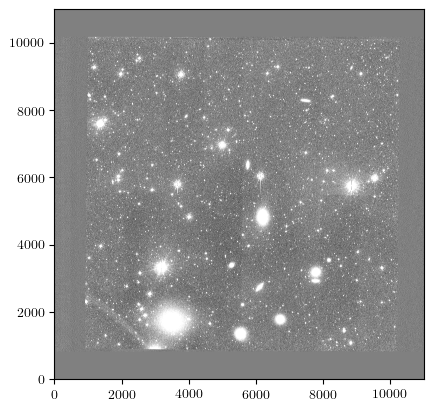

In [3]:
zscale = ZScaleInterval()
plt.imshow ( zscale(section), origin = 'lower', cmap = "gray" )
plt.imsave ( fname='images/SPLUS-s27s34_R_swp.png', arr = zscale(section), cmap = 'gray_r', format = 'png' )
plt.show()

In [4]:
# load image
img = cv2.imread ( 'images/SPLUS-s27s34_R_swp.png', cv2.IMREAD_GRAYSCALE)

# threshold
thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY)[1]
#thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

# apply open morphology
#kernel = np.ones((5,5), np.uint8)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
morph = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

In [5]:
# get bounding box coordinates from largest external contour
contours = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
big_contour = max(contours, key=cv2.contourArea)
x,y,w,h = cv2.boundingRect(big_contour)

In [6]:
mask_file = 'images/SPLUS-s27s34_R_swp_MASK.fits'
mask_border = morph/255
masked = np.multiply(section, (~mask_border.astype(bool)))
fits.writeto ( mask_file, masked, hdu.header, overwrite = True ) 
print ( '[+] File created: ', mask_file )

[+] File created:  images/SPLUS-s27s34_R_swp_MASK.fits


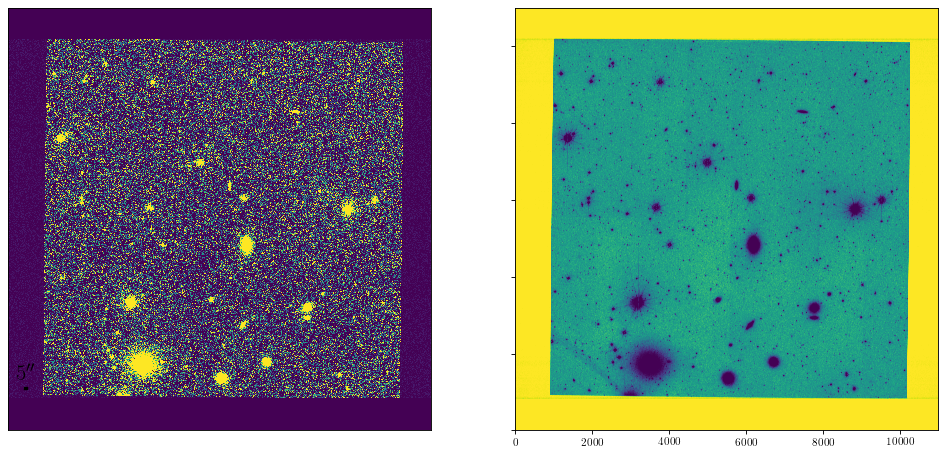

In [7]:
scaled_image = section #np.log10 ( section )
vmin, vmax = AsymmetricPercentileInterval ( lower_percentile = 50, 
                                          upper_percentile = 95 ).get_limits ( scaled_image )
args = dict(contrast = 0.35, scale_bar_y_offset = 1.2, scale_bar_color = 'k', zmin = vmin, zmax = vmax)

fig, (ax0, ax1) = plt.subplots ( ncols = 2, nrows = 1, figsize = (15, 10), dpi = 80, sharey = True )
_ = display_single(scaled_image, ax=ax0, **args )

# Overplot the mask
_ = ax1.imshow(thresh, origin='lower')
plt.show()